## Simulation Framework 

In [56]:
import import_ipynb
import math 
import importlib
import random
import copy
import numpy as np
import matplotlib.pyplot as plt

# import functions from model_evaluation.ipynb  
import model_evaluation 

In [2]:
# simulation parameters 

# number of groups
n_groups = 10 

# number of agents 
n_agents = 10

# Iterations for group distributions 
iterations = 1000

# Number of vote distributions 
sim = 100

### Group Distributions 

In [3]:
# create random distributions 
def distribute_agents(n_agents, n_groups):
    """
    This function randomly selects a subset of group indices for each agent. The number of groups for each agent is randomly chosen between 1 and the total number of groups.
    :returns (list of lists): Each inner list represents the agents assigned to a particular group.
    """
    group_dist = [[] for _ in range(n_groups)]

    for agent in range(n_agents):
        groups = random.sample(range(n_groups), random.randint(1, n_groups))
        for group in groups:
            group_dist[group].append(agent)

    return group_dist

In [4]:
# Create random group distributions with a gradual transition from one to the other extreme 
def gradual_distribution_transition(n_agents, n_groups, iterations):
    """
    This function starts with a distribution where each group contains only one agent and gradually modifies it in each iteration.
    :returns (list of lists): Each inner list represents the agents assigned to a particular group.
    """
    # Initial distribution: Each group contains only one agent
    group_dist = [[agent] for agent in range(n_agents)]

    # List to store distributions at each iteration
    distributions = [copy.deepcopy(group_dist)]

    for _ in range(iterations):  # Start from iteration 1
        # Randomly select a group
        source_group = random.randint(0, n_groups - 1)
        
        # Randomly select a destination group different from the source group
        possible_destination_groups = [group for group in range(n_groups) if group != source_group]
        destination_group = random.choice(possible_destination_groups)

        # Randomly select an agent from the source group
        if group_dist[source_group]:
            agent_to_move = random.choice(group_dist[source_group])

            # Move the agent to the destination group if not already present
            if agent_to_move not in group_dist[destination_group]:
                group_dist[destination_group].append(agent_to_move)
            else:
                continue

        # Save the current distribution (deep copy to avoid referencing the same object)
        distributions.append(copy.deepcopy(group_dist))

    return distributions

In [22]:
result_group_distributions = gradual_distribution_transition(n_agents=n_agents, n_groups=n_groups, iterations=iterations)
# print(result_group_distributions[-1])
print(len(result_group_distributions))

91


In [6]:
# Custom Group Distributions 

# result_group_distributions = [[[0], [1]], [[0, 1], [1]], [[0, 1], [1, 0]]]
# result_group_distributions = [[[0], [1]], [[0, 1], [1, 0]]]
# result_group_distributions = [[[0, 1], [1]], [[0, 1], [1, 0]]]
# print(result_group_distributions)

### Vote Distribution 

In [6]:
# define fixed vote distribution 
def vote_distribution_fixed(n_agents, votes_agent):
    return [votes_agent] * n_agents

In [ ]:
vote_dist = vote_distribution_fixed(n_agents=n_agents, votes_agent=5)
# print(vote_dist)

In [7]:
def vote_distribution_random(n_agents, sim):
    list_vote_dist = []
    for _ in range(sim):
        vote_dist = [random.randint(1, 100) for _ in range(n_agents)]
        list_vote_dist.append(vote_dist)
    return list_vote_dist 

In [11]:
list_vote_dist = vote_distribution_random(n_agents=n_agents, sim=sim)
# print(list_vote_dist)

### Group Membership

In [12]:
list_result_group_memberships = []
for i in range(len(result_group_distributions)): 
    result_group_memberships = model_evaluation.group_memberships(groups=result_group_distributions[i], n_agents=n_agents)
    list_result_group_memberships.append(result_group_memberships)

# print(list_result_group_memberships[-1])

In [10]:
# result_commom_group = model_evaluation.common_group(1,0, memberships_group=list_result_group_memberships[1])
# print(result_commom_group)

In [11]:
# result_K = model_evaluation.K(agent_i=0, group=result_group_distributions[1][1], votes=vote_dist, memberships_group=list_result_group_memberships[1])
# print(result_K)

### Model Terms 

In [45]:
# first term 
output_first_term = []
for j in range(len(list_vote_dist)):
    dict_result_group_first_term = {}
    list_result_aggregated_weight_term_1 = []
    for i in range(len(result_group_distributions)):  # len(result_group_distributions) == len(list_result_group_memberships)
        result_groups, result_aggregate_weight = model_evaluation.first_term(groups=result_group_distributions[i], votes=list_vote_dist[j], memberships_group=list_result_group_memberships[i])
        dict_result_group_first_term[i] = {'individual_contributions': result_groups}
        list_result_aggregated_weight_term_1.append(result_aggregate_weight)
    output_first_term.append(list_result_aggregated_weight_term_1)

# print(list_result_aggregated_weight_term_1)
# print(dict_result_group_first_term)
# print(output_first_term[0])
# print(len(output_first_term[0]))

In [19]:
# interaction terms
output_interaction_terms = []
for j in range(len(list_vote_dist)):
    dict_result_individual_interaction_terms = {}
    list_result_aggregated_weight_interaction_terms = []
    for i in range(len(result_group_distributions)):  # len(result_group_distributions) == len(list_result_group_memberships)
        result_individual, result_aggregated = model_evaluation.interaction_terms(groups=result_group_distributions[i], memberships_group=list_result_group_memberships[i], votes=list_vote_dist[j])
        dict_result_individual_interaction_terms[i] = {'individual_contributions': result_individual}
        list_result_aggregated_weight_interaction_terms.append(result_aggregated)
    output_interaction_terms.append(list_result_aggregated_weight_interaction_terms)

# print(dict_result_individual_interaction_terms)
# print(list_result_aggregated_weight_interaction_terms)   


In [46]:
# print(output_interaction_terms[0])
# print(len(output_interaction_terms))
# print(len(output_interaction_terms[0]))

### Plurality and QV Scores 

In [47]:
output_plurality_scores = []
for i in range(sim):
    list_plurality_scores = []
    for j in range(len(result_group_distributions)):   
        plurality_score = model_evaluation.connection_oriented_cluster_match(term_1=output_first_term[i][j], interaction_terms=output_interaction_terms[i][j])
        list_plurality_scores.append(plurality_score)
    output_plurality_scores.append(list_plurality_scores)

# print(output_plurality_scores)
# print(len(output_plurality_scores))
# print(len(output_plurality_scores[0]))


In [48]:
output_qv_scores = []
for i in range(len(list_vote_dist)):
    _, result_sum_quadratic_votes = model_evaluation.quadratic_voting(votes=list_vote_dist[i])
    output_qv_scores.append(result_sum_quadratic_votes)

# print(output_qv_scores)
# print(len(output_qv_scores))

### Jaccard Index 

In [55]:
global_jaccard_index = []
for i in range(len(result_group_distributions)):
    pairwise_jaccard_matrix = model_evaluation.pairwise_jaccard_similarity(groups=result_group_distributions[i])
    # print("Pairwise Jaccard Similarity Matrix:")
    # for row in pairwise_jaccard_matrix:
    #    print(row)

    global_similarity = model_evaluation.global_jaccard_similarity(pairwise_jaccard_matrix)
    global_jaccard_index.append(global_similarity)

# print(global_jaccard_index)


In [49]:
y_values = np.array(output_plurality_scores)
# print(y_values)

In [50]:
y_values_transposed = np.transpose(y_values)
# print(y_values_transposed[0])

### Plot


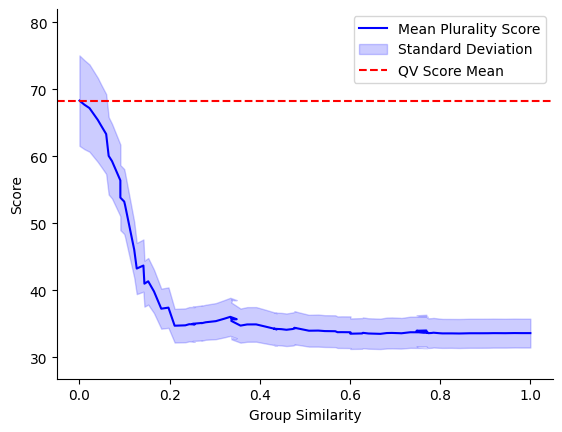

In [53]:
x_values = global_jaccard_index
y_values = np.array(output_plurality_scores)
qv_scores = np.array(output_qv_scores)

# Transpose the matrix to calculate mean and confidence interval by column
y_values_transposed = np.transpose(y_values)

# Calculate mean and standard deviation
mean_values = np.mean(y_values_transposed, axis=1)
std_values = np.std(y_values_transposed, axis=1)

# Plot
plt.plot(x_values, mean_values, color='b', label='Mean Plurality Score')
plt.fill_between(x_values, mean_values - std_values, mean_values + std_values, color='b', alpha=0.2, label='Standard Deviation')

qv_mean = np.mean(qv_scores)
plt.axhline(y=qv_mean, color='r', linestyle='--', label='QV Score Mean')

# Plot QV score standard deviation as a shaded band
# qv_std = np.std(qv_scores)
# plt.fill_between(x_values, qv_mean - qv_std, qv_mean + qv_std, color='r', alpha=0.2, label='QV Score Standard Deviation')

plt.xlabel('Group Similarity')
plt.ylabel('Score')
plt.title('')  

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.ylim(0.8 * np.min(mean_values), 1.2 * np.max(mean_values))

plt.legend()

plt.show()
